## First steps with TensorFlow

#### An end-to-end example: A linear classifier in pure TensorFlow

**Generating two classes of random points in a 2D plane**

In [1]:
import numpy as np
import tensorflow as tf

num_samples_per_class = 1000
negative_samples = np.random.multivariate_normal(
    mean=[0, 3],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)
positive_samples = np.random.multivariate_normal(
    mean=[3, 0],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)

2023-11-17 00:09:12.468600: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


**Stacking the two classes into an array with shape (2000, 2)**

In [2]:
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)

**Generating the corresponding targets (0 and 1)**

In [3]:
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype="float32"), np.ones((num_samples_per_class, 1), dtype="float32")))

**Plotting the two point classes**

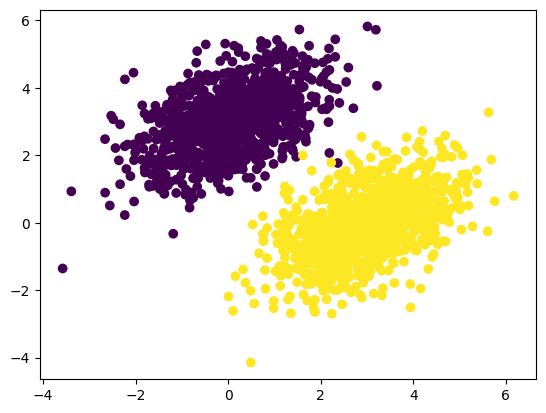

In [4]:
import matplotlib.pyplot as plt
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

**Creating the linear classifier variables**

In [5]:
input_dim = 2
output_dim = 1
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

**The forward pass function**

In [6]:
def model(inputs):
    return tf.matmul(inputs, W) + b

**The mean squared error loss function**

In [7]:
def square_loss(targets, predictions):
    per_sample_losses = tf.square(targets - predictions)
    return tf.reduce_mean(per_sample_losses)

**The training step function**

In [8]:
learning_rate = 0.1

def training_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = square_loss(targets, predictions)
    grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
    W.assign_sub(grad_loss_wrt_W * learning_rate)
    b.assign_sub(grad_loss_wrt_b * learning_rate)
    return loss

**The batch training loop**

In [9]:
for step in range(40):
    loss = training_step(inputs, targets)
    print(f"Loss at step {step}: {loss:.4f}")

Loss at step 0: 2.7911
Loss at step 1: 0.4101
Loss at step 2: 0.1639
Loss at step 3: 0.1260
Loss at step 4: 0.1141
Loss at step 5: 0.1060
Loss at step 6: 0.0989
Loss at step 7: 0.0925
Loss at step 8: 0.0867
Loss at step 9: 0.0814
Loss at step 10: 0.0765
Loss at step 11: 0.0721
Loss at step 12: 0.0680
Loss at step 13: 0.0643
Loss at step 14: 0.0609
Loss at step 15: 0.0578
Loss at step 16: 0.0550
Loss at step 17: 0.0525
Loss at step 18: 0.0501
Loss at step 19: 0.0480
Loss at step 20: 0.0460
Loss at step 21: 0.0442
Loss at step 22: 0.0426
Loss at step 23: 0.0411
Loss at step 24: 0.0397
Loss at step 25: 0.0385
Loss at step 26: 0.0374
Loss at step 27: 0.0363
Loss at step 28: 0.0354
Loss at step 29: 0.0345
Loss at step 30: 0.0337
Loss at step 31: 0.0330
Loss at step 32: 0.0324
Loss at step 33: 0.0318
Loss at step 34: 0.0312
Loss at step 35: 0.0307
Loss at step 36: 0.0303
Loss at step 37: 0.0298
Loss at step 38: 0.0295
Loss at step 39: 0.0291


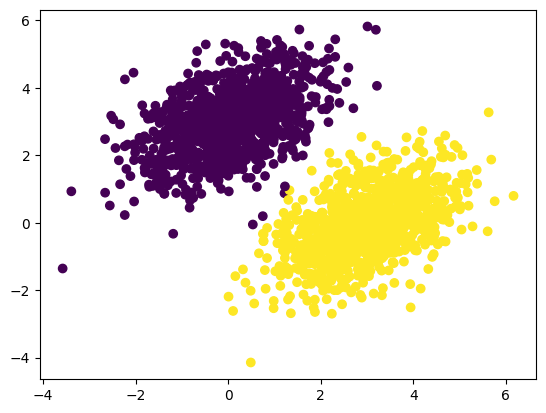

In [10]:
predictions = model(inputs)
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.show()

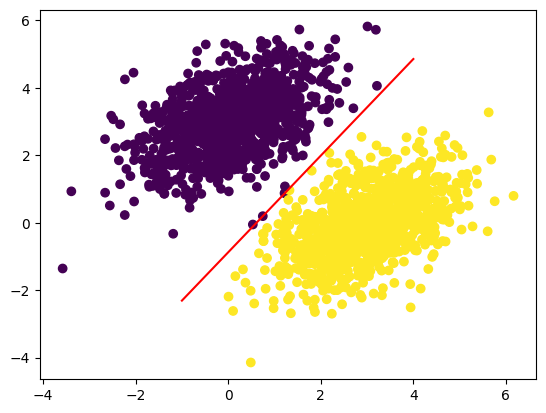

In [11]:
x = np.linspace(-1, 4, 100)
y = - W[0] /  W[1] * x + (0.5 - b) / W[1]
plt.plot(x, y, "-r")
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)

## Anatomy of a neural network: Understanding core Keras APIs

### Layers: The building blocks of deep learning

#### The base Layer class in Keras

**A `Dense` layer implemented as a `Layer` subclass**

In [12]:
from tensorflow import keras

class SimpleDense(keras.layers.Layer):

    def __init__(self, units, activation=None):
        super().__init__()
        self.units = units
        self.activation = activation

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.W = self.add_weight(shape=(input_dim, self.units),
                                 initializer="random_normal")
        self.b = self.add_weight(shape=(self.units,),
                                 initializer="zeros")

    def call(self, inputs):
        y = tf.matmul(inputs, self.W) + self.b
        if self.activation is not None:
            y = self.activation(y)
        return y

In [13]:
my_dense = SimpleDense(units=32, activation=tf.nn.relu)
input_tensor = tf.ones(shape=(2, 784))
output_tensor = my_dense(input_tensor)
print(output_tensor.shape)

(2, 32)


#### Automatic shape inference: Building layers on the fly

In [14]:
from tensorflow.keras import layers
layer = layers.Dense(32, activation="relu")

In [15]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential([
    layers.Dense(32, activation="relu"),
    layers.Dense(32)
])

In [16]:
model = keras.Sequential([
    SimpleDense(32, activation="relu"),
    SimpleDense(64, activation="relu"),
    SimpleDense(32, activation="relu"),
    SimpleDense(10, activation="softmax")
])

### From layers to models

### The "compile" step: Configuring the learning process

In [17]:
model = keras.Sequential([keras.layers.Dense(1)])
model.compile(optimizer="adam", loss="mean_squared_error", metrics=["accuracy"])

In [18]:
model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.BinaryAccuracy()])

### Picking a loss function

### Understanding the fit() method

**Calling `fit()` with NumPy data**

In [19]:
history = model.fit(
    inputs,
    targets,
    epochs=5,
    batch_size=128
)

Epoch 1/5
16/16 [==============================] - 0s 1ms/step - loss: 11.2893 - binary_accuracy: 0.4655
Epoch 2/5
16/16 [==============================] - 0s 1ms/step - loss: 10.8000 - binary_accuracy: 0.4655
Epoch 3/5
16/16 [==============================] - 0s 1ms/step - loss: 10.3927 - binary_accuracy: 0.4625
Epoch 4/5
16/16 [==============================] - 0s 993us/step - loss: 10.0005 - binary_accuracy: 0.4595
Epoch 5/5
16/16 [==============================] - 0s 1ms/step - loss: 9.6194 - binary_accuracy: 0.4570


In [20]:
history.history

{'loss': [11.289302825927734,
  10.799955368041992,
  10.392660140991211,
  10.000466346740723,
  9.61943531036377],
 'binary_accuracy': [0.46549999713897705,
  0.46549999713897705,
  0.4625000059604645,
  0.4595000147819519,
  0.4569999873638153]}

### Monitoring loss and metrics on validation data

**Using the `validation_data` argument**

In [21]:
model = keras.Sequential([keras.layers.Dense(1)])
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.1),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.BinaryAccuracy()])

indices_permutation = np.random.permutation(len(inputs))
shuffled_inputs = inputs[indices_permutation]
shuffled_targets = targets[indices_permutation]

num_validation_samples = int(0.3 * len(inputs))
val_inputs = shuffled_inputs[:num_validation_samples]
val_targets = shuffled_targets[:num_validation_samples]
training_inputs = shuffled_inputs[num_validation_samples:]
training_targets = shuffled_targets[num_validation_samples:]
model.fit(
    training_inputs,
    training_targets,
    epochs=5,
    batch_size=16,
    validation_data=(val_inputs, val_targets)
)

Epoch 1/5
88/88 [==============================] - 0s 2ms/step - loss: 0.0846 - binary_accuracy: 0.9486 - val_loss: 0.0394 - val_binary_accuracy: 0.9917
Epoch 2/5
88/88 [==============================] - 0s 1ms/step - loss: 0.0680 - binary_accuracy: 0.9621 - val_loss: 0.0531 - val_binary_accuracy: 0.9983
Epoch 3/5
88/88 [==============================] - 0s 1ms/step - loss: 0.0736 - binary_accuracy: 0.9657 - val_loss: 0.0673 - val_binary_accuracy: 0.9983
Epoch 4/5
88/88 [==============================] - 0s 1ms/step - loss: 0.0739 - binary_accuracy: 0.9521 - val_loss: 0.0701 - val_binary_accuracy: 0.9750
Epoch 5/5
88/88 [==============================] - 0s 1ms/step - loss: 0.0750 - binary_accuracy: 0.9543 - val_loss: 0.1582 - val_binary_accuracy: 0.9350


### Inference: Using a model after training

In [22]:
predictions = model.predict(val_inputs, batch_size=128)
print(predictions[:10])

5/5 [==============================] - 0s 2ms/step
[[ 0.228634  ]
 [ 1.6771209 ]
 [ 1.3900249 ]
 [ 0.29342243]
 [ 0.06960899]
 [ 0.42097038]
 [ 0.3405561 ]
 [-0.12224847]
 [ 1.3219197 ]
 [ 1.9424632 ]]
